<a href="https://colab.research.google.com/github/tutsilianna/Neural_networks_NLP_HW/blob/main/practice_CNN_for_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 02: Dealing with texts using CNN

Today we're gonna apply the newly learned tools for the task of predicting job salary.


Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). _Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0).

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [ ]:
# Do this only once
!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    66    0    66    0     0     60      0 --:--:--  0:00:01 --:--:--    60
100   299  100   299    0     0    172      0  0:00:01  0:00:01 --:--:--   172
100  119M  100  119M    0     0  13.4M      0  0:00:08  0:00:08 --:--:-- 18.8M
Train_rev1.csv


In [ ]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [ ]:
data.head(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

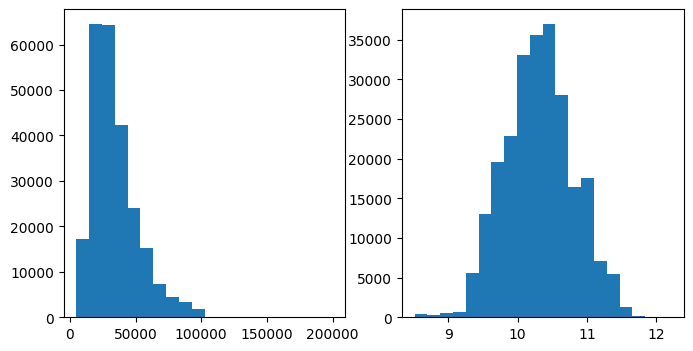

In [ ]:
data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna(
    "NaN"
)  # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
76329,69006800,English teacher needed ASAP,An outstanding school with many outstanding fe...,"Sutton Coldfield, West Midlands",Sutton Coldfield,NaN,contract,PK Education,Teaching Jobs,110 - 140/day,30000,cv-library.co.uk,10.308986
79213,69017554,Assistant Site Manager,Assistant Site Manager wanted for large reside...,"South London, London",South East London,NaN,contract,Engage Construction,Trade & Construction Jobs,18/hour,34560,cv-library.co.uk,10.450481
243919,72692045,English Teachers,ENGLISH TEACHERS Required part time for London...,London,London,NaN,permanent,Londonjobs Evening Standard Ptner,Teaching Jobs,8.50 ph,16320,jobsite.co.uk,9.700208


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [ ]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
def normalize(text):
  # >> <YOUR CODE HERE>
  text = str(text).lower()
  tokens = tokenizer.tokenize(text)
  return " ".join(tokens)
  # << <YOUR CODE HERE>

data[text_columns] = data[text_columns].applymap(normalize)

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
from collections import Counter
from tqdm import tqdm as tqdm

token_counts = Counter() # <YOUR CODE HERE>

# hint: you may or may not want to use collections.Counter

In [ ]:
%%time

for _, row in data[text_columns].iterrows():
  for text in row:
    token_counts.update(text.split(" "))

CPU times: user 25.3 s, sys: 66.5 ms, total: 25.3 s
Wall time: 25.3 s


In [ ]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


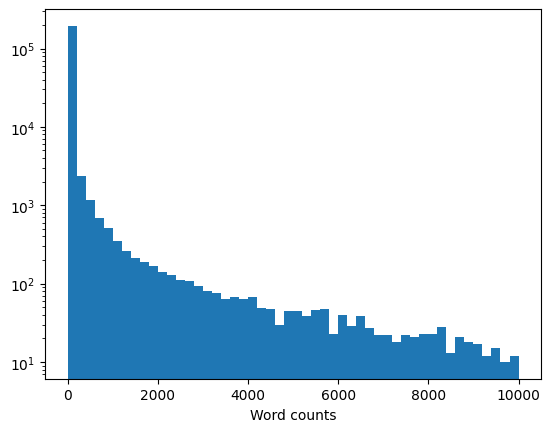

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

In [ ]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
# You have already done that ;)

token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float("inf"))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, : len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print("\n".join(data["Title"][::100000].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
from sklearn.feature_extraction import DictVectorizer


# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(
    lambda comp: comp if comp in recognized_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [ ]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(
    matrix,
    keep_prop,
    replace_with=UNK_IX,
    pad_ix=PAD_IX,
):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
a = make_batch(data_train[:3], max_len=10)

In [ ]:
print([x for x in a])
print(len(a['Title']))

['Title', 'FullDescription', 'Categorical', 'Log1pSalary']
3


#### Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn

In [ ]:
# You will need these to make it simple

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

To generate minibatches we will use simple pyton generator.

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

In [ ]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [ ]:
len(tokens), len(categorical_vectorizer.vocabulary_)

(34158, 3768)

In [ ]:
# Here is some startup code:
n_tokens = len(tokens)
n_cat_features = len(categorical_vectorizer.vocabulary_)
hid_size = 64
simple_model = nn.Sequential()

simple_model.add_module("emb", nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size))
simple_model.add_module("reorder", Reorder())
# >> <YOUR CODE HERE>
simple_model.add_module(
    "conv1", nn.Conv1d(in_channels=hid_size, out_channels=hid_size*2, kernel_size=3)
)
simple_model.add_module("relu1", nn.ReLU())
simple_model.add_module(
    "conv2", nn.Conv1d(in_channels=hid_size*2, out_channels=hid_size*2, kernel_size=3)
)
simple_model.add_module("relu2", nn.ReLU())
simple_model.add_module("bn1", nn.BatchNorm1d(num_features=hid_size * 2))
simple_model.add_module(
    "conv3", nn.Conv1d(in_channels=hid_size*2, out_channels=hid_size*2, kernel_size=2)
)
simple_model.add_module("relu3", nn.ReLU())
simple_model.add_module("adaptive_pool", nn.AdaptiveMaxPool1d(1))
simple_model.add_module("flatten", nn.Flatten())

simple_model.add_module("out", nn.Linear(2*hid_size, 1))
# <<

__Remember!__ We are working with regression problem and predicting only one number.

In [ ]:
# Try this to check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch["FullDescription"], dtype=torch.long))

tensor([[-0.0988],
        [-0.0545],
        [ 0.1067]], grad_fn=<AddmmBackward0>)

In [ ]:
device = torch.device("cuda") # cuda

In [ ]:
device

device(type='cuda')

In [ ]:
simple_model.to(device)

Sequential(
  (emb): Embedding(34158, 64)
  (reorder): Reorder()
  (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (relu3): ReLU()
  (adaptive_pool): AdaptiveMaxPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

And now simple training pipeline:

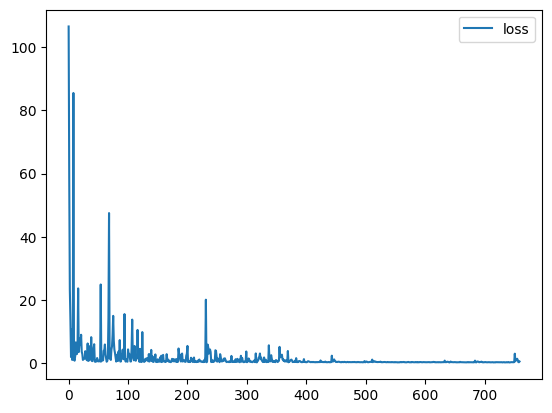

In [ ]:
from IPython.display import clear_output
from random import sample

epochs = 1

model = simple_model
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() # <YOUR CODE HERE>

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train)):
        opt.zero_grad()
        # Preprocessing the batch data and target
        batch = torch.tensor(batch['FullDescription'], dtype=torch.long).to(device)
        target = torch.tensor(target).to(device)


        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss = loss_func(predictions, target) # <YOUR CODE HERE>


        # train with backprop
        # >> <YOUR CODE HERE>
        loss.backward()
        opt.step()
        opt.zero_grad()
        # << <YOUR CODE HERE>

        history.append(loss.item())
        if (idx+1)%10==0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()

To evaluate the model it can be switched to `eval` state.

In [ ]:
simple_model.eval()

Sequential(
  (emb): Embedding(34158, 64)
  (reorder): Reorder()
  (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (relu3): ReLU()
  (adaptive_pool): AdaptiveMaxPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

Let's check the model quality.

In [ ]:
from tqdm import tqdm, tqdm_notebook


def print_metrics(model, data, batch_size=256, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in tqdm(
        iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)
    ):
        batch = torch.tensor(batch_x["FullDescription"], dtype=torch.long).to(device)
        batch_pred = model(batch)[:, 0].detach().cpu().numpy()
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error


print_metrics(simple_model, data_train, name="Train")
print_metrics(simple_model, data_val, name="Val");

765it [00:37, 20.14it/s]


Train results:
Mean square error: 0.24660
Mean absolute error: 0.34184


192it [00:10, 18.48it/s]

Val results:
Mean square error: 0.24933
Mean absolute error: 0.34311


### Bonus area: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [ ]:
class ThreeInputsNet(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super(ThreeInputsNet, self).__init__()
        self.title_emb = nn.Embedding(n_tokens, embedding_dim=hid_size)
        # >> <YOUR CODE HERE>
        self.title_conv1 = nn.Conv1d(in_channels=hid_size, out_channels=hid_size*2, kernel_size=1)
        self.title_relu1 = nn.ReLU()
        self.title_conv2 = nn.Conv1d(in_channels=hid_size*2, out_channels=hid_size*2, kernel_size=1)
        self.title_relu2 = nn.ReLU()
        self.title_bn    = nn.BatchNorm1d(hid_size*2)
        self.title_conv3 = nn.Conv1d(in_channels=hid_size*2, out_channels=hid_size*2, kernel_size=1)
        self.title_relu3 = nn.ReLU()
        self.title_pol   = nn.AdaptiveMaxPool1d(1)
        # <<

        self.full_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        # >> <YOUR CODE HERE>
        self.full_conv1 = nn.Conv1d(in_channels=hid_size, out_channels=hid_size*2, kernel_size=1)
        self.full_conv2 = nn.Conv1d(in_channels=hid_size*2, out_channels=hid_size*2, kernel_size=1)
        self.full_bn    = nn.BatchNorm1d(hid_size*2)
        self.full_conv3 = nn.Conv1d(in_channels=hid_size*2, out_channels=hid_size*2, kernel_size=1)
        self.full_pol   = nn.AdaptiveMaxPool1d(1)
        # <<

        self.category_out = nn.Linear(n_cat_features, hid_size) # <YOUR CODE HERE>



    def forward(self, whole_input):
        input1, input2, input3 = whole_input
        title_beg = self.title_emb(input1).permute((0, 2, 1))
        title_conv1 =  self.title_conv1(title_beg).squeeze(2)          # <YOUR CODE HERE>
        title_relu1 = self.title_relu1(title_conv1)
        title_conv2 = self.title_conv2(title_relu1) #
        title_relu2 = self.title_relu2(title_conv2)
        title_bn = self.title_bn(title_relu2)
        title_conv3 = self.title_conv3(title_bn)
        title_relu3 = self.title_relu3(title_conv3)
        title_pol = self.title_pol(title_relu3)
        title = self.title_conv3(title_bn)


        # full_beg = self.full_emb(input2).permute((0, 2, 1))
        # full = self.full_conv1(full_beg).squeeze(2)              # <YOUR CODE HERE>
        full_beg = self.full_emb(input2).permute((0, 2, 1))
        full_conv1 =  self.full_conv1(full_beg).squeeze(2)          # <YOUR CODE HERE>
        full_conv2 = self.full_conv2(full_conv1) #
        full_bn = self.full_bn(full_conv2)
        full_conv3 = self.full_conv3(full_bn)
        full_pol = self.full_pol(full_conv3)
        full = self.full_conv3(full_pol)

        category = self.category_out(input3.to(device))         # <YOUR CODE HERE>

        concatenated = torch.cat(
            [
            title.view(title.size(0), -1),
            full.view(full.size(0), -1),
            category.view(category.size(0), -1)
            ],
            dim=1)

        linear_layer = nn.Linear(concatenated.size(1), 1)      # <YOUR CODE HERE>
        out = linear_layer(concatenated)                       # <YOUR CODE HERE>

        return out

In [ ]:
ThreeInputsNet()

ThreeInputsNet(
  (title_emb): Embedding(34158, 64)
  (title_conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (title_relu1): ReLU()
  (title_conv2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (title_relu2): ReLU()
  (title_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (title_conv3): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (title_relu3): ReLU()
  (title_pol): AdaptiveMaxPool1d(output_size=1)
  (full_emb): Embedding(34158, 64)
  (full_conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (full_conv2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (full_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (full_conv3): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (full_pol): AdaptiveMaxPool1d(output_size=1)
  (category_out): Linear(in_features=3768, out_features=64, bias=True)
)

In [ ]:
modelThreeInputsNet = ThreeInputsNet()
deviceThreeInputsNet = torch.device("cpu")
modelThreeInputsNet.to(deviceThreeInputsNet)
optThreeInputsNet = torch.optim.Adam(modelThreeInputsNet.parameters())
loss_func = nn.MSELoss()

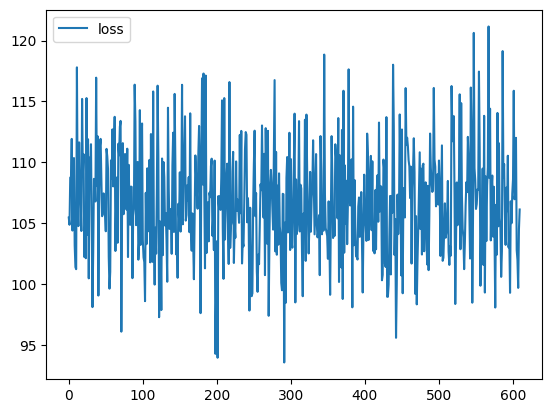

KeyboardInterrupt: 

In [ ]:
from IPython.display import clear_output

def trainThreeInputsNet(model, device, epochs, data):
    history = []
    for epoch_num in range(epochs):
        for idx, (batch, target) in enumerate(iterate_minibatches(data)):
            opt.zero_grad()

            batch_title = torch.tensor(batch['Title'], dtype=torch.long).to(device)
            batch_full  = torch.tensor(batch['FullDescription'], dtype=torch.long).to(device)
            batch_cat   = torch.tensor(batch['Categorical'], dtype=torch.float32).to(device)

            target = torch.tensor(target, dtype=torch.float32).to(device)

            predictions = model((batch_title, batch_full, batch_cat))
            predictions = predictions.view(predictions.size(0))

            loss = loss_func(predictions, target)

            loss.backward()
            opt.step()
            opt.zero_grad()

            history.append(loss.item())
            if (idx+1)%10==0:
                clear_output(True)
                plt.plot(history, label='loss')
                plt.legend()
                plt.show()

trainThreeInputsNet(modelThreeInputsNet, deviceThreeInputsNet, epochs, data_train)

### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks.
*Hint: try to build networks with ~same number of paremeters.*

In [ ]:
len(tokens), len(categorical_vectorizer.vocabulary_)

(34158, 3768)

In [ ]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size=[len(tokens), len(tokens), len(categorical_vectorizer.vocabulary_)], hidden_size=64, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Встраивание для каждого входа
        self.embedding_title = nn.Embedding(input_size[0], 4*hidden_size)
        self.embedding_desc = nn.Embedding(input_size[1], 4*hidden_size)
        self.embedding_cat = nn.Embedding(input_size[2], 4*hidden_size)

        # LSTM слой
        self.lstm = nn.LSTM(4 * hidden_size, 4*hidden_size, num_layers, batch_first=True)

        # Полносвязный слой для выхода
        self.fc = nn.Linear(4*hidden_size, 1)

    def forward(self, title, desc, cat):
        # Встраивание каждого входа
        title = self.embedding_title(title).permute((2, 1, 0))
        desc = self.embedding_desc(desc).permute((2, 1, 0))
        cat = self.embedding_cat(cat).permute((2, 1, 0))
        print(f'title: {title.shape},\ndesc: {desc.shape},\ncat: {cat.shape}\n')
        # Объединение встраиваний
        combined = torch.cat((title, desc, cat), dim=1)
        print(f'combined: {combined.shape}\n')
        # print(self.num_layers, combined.size(0), self.hidden_size)
        # LSTM слой
        h0 = torch.zeros(self.num_layers, combined.size(0), 4*self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, combined.size(0), 4*self.hidden_size).to(device)
        out, _ = self.lstm(combined, (h0, c0))
        print(f'out.shape: {out.shape},\nh0.shape: {h0.shape},\nc0.shape: {c0.shape}\n')
        # Выход через полносвязный слой
        out = self.fc(out[:, -1, :])
        return out

# ------------------------------------------------------------------------------
modelRNNtorch = SimpleLSTM()
device = torch.device("cuda")
modelRNNtorch.to(device)
opt = torch.optim.Adam(modelRNNtorch.parameters())
loss_func = nn.MSELoss()
epochs = 1

def trainRNNtorch(model, device, epochs, data):
    history = []
    for epoch_num in range(epochs):
        for idx, (batch, target) in enumerate(iterate_minibatches(data)):
            opt.zero_grad()

            batch_title = torch.tensor(batch['Title'], dtype=torch.long).to(device)
            batch_full  = torch.tensor(batch['FullDescription'], dtype=torch.long).to(device)
            batch_cat   = torch.tensor(batch['Categorical'], dtype=torch.long).to(device)

            target = torch.tensor(target, dtype=torch.float32).to(device)
            print(f'target: {target.shape}\n')
            predictions = model(batch_title, batch_full, batch_cat)
            predictions = predictions.view(predictions.size(0))

            loss = loss_func(predictions, target)

            loss.backward()
            opt.step()
            opt.zero_grad()

            history.append(loss.item())
            if (idx+1)%10==0:
                clear_output(True)
                plt.plot(history, label='loss')
                plt.legend()
                plt.show()

trainRNNtorch(modelRNNtorch, device, epochs, data_train)

target: torch.Size([256])

title: torch.Size([256, 30, 256]),
desc: torch.Size([256, 861, 256]),
cat: torch.Size([256, 3768, 256])

combined: torch.Size([256, 4659, 256])



OutOfMemoryError: CUDA out of memory. Tried to allocate 5.69 GiB. GPU 0 has a total capacity of 22.17 GiB of which 5.25 GiB is free. Process 2892 has 16.91 GiB memory in use. Of the allocated memory 15.68 GiB is allocated by PyTorch, and 1.01 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# using built-in RNN layers in PyTorch

class RNNtorch(nn.Module):
    def __init__(self, vocab_size=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, num_layers=1):
        super(RNNtorch, self).__init__()

        self.hidden_size = hid_size
        self.num_layers  = num_layers

        self.title_emb    = nn.Embedding(vocab_size, embedding_dim=hid_size)
        self.title_bn     = nn.BatchNorm1d(hid_size*2)
        self.full_emb     = nn.Embedding(vocab_size, embedding_dim=hid_size)
        self.full_bn      = nn.BatchNorm1d(hid_size*2)
        self.category_out = nn.Linear(n_cat_features, hid_size) #

        self.rnn          = nn.RNN(4 * hid_size, hid_size, num_layers, batch_first=True, nonlinearity='relu')
        self.fc           = nn.Linear(hid_size, 1)

    def forward(self, batch_title, batch_full, batch_cat):
        title_     = self.title_emb(batch_title).permute((0, 2, 1))# .permute((1, 0, 2))
        print(title_.shape)
        title      = self.title_bn(title_)
        full_      = self.full_emb(batch_full).permute((1, 0, 2))
        full       = self.title_bn(full_)
        category   = self.category_out(batch_cat.to(device))

        print("Размеры:")
        print("title_:", title.shape)
        print("full_:", full.shape)
        print("category_:", category.shape)

        embedded_inputs = torch.cat((title, full, category), dim=2)
        # embedded_inputs = torch.cat(
        #     [
        #     title_.contiguous().view(title_.size(0), -1),
        #     full_.contiguous().view(full_.size(0), -1),
        #     category_.contiguous().view(category_.size(0), -1)
        #     ],
        #     dim=1)

        print("***")
        print(len(embedded_inputs), len(embedded_inputs[0]))
        # Проход через RNN
        output, _ = self.rnn(title_)

        # Получение последнего выхода
        output = output[:, -1, :]

        # Проход через полносвязный слой
        prediction = self.fc(output)
        return prediction

# ------------------------------------------------------------------------------
modelRNNtorch = RNNtorch()
device = torch.device("cpu:0")
modelRNNtorch.to(device)
opt = torch.optim.Adam(modelRNNtorch.parameters())
loss_func = nn.MSELoss()

def trainRNNtorch(model, device, epochs, data):
    history = []
    for epoch_num in range(epochs):
        for idx, (batch, target) in enumerate(iterate_minibatches(data)):
            opt.zero_grad()

            batch_title = torch.tensor(batch['Title'], dtype=torch.long).to(device)
            batch_full  = torch.tensor(batch['FullDescription'], dtype=torch.long).to(device)
            batch_cat   = torch.tensor(batch['Categorical'], dtype=torch.float32).to(device)

            target = torch.tensor(target, dtype=torch.float32).to(device)

            predictions = model(batch_title, batch_full, batch_cat)
            predictions = predictions.view(predictions.size(0))

            loss = loss_func(predictions, target)

            loss.backward()
            opt.step()
            opt.zero_grad()

            history.append(loss.item())
            if (idx+1)%10==0:
                clear_output(True)
                plt.plot(history, label='loss')
                plt.legend()
                plt.show()

trainRNNtorch(modelRNNtorch, device, epochs, data_train)

torch.Size([256, 64, 18])


RuntimeError: running_mean should contain 64 elements not 128

In [ ]:
# using built-in RNN layers in PyTorch

class RNNtorch(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, num_layers=1):
        super(RNNtorch, self).__init__()

        self.hidden_size = hid_size
        self.num_layers  = num_layers

        self.title_emb    = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        # self.title_conv   = nn.Conv1d(in_channels=hid_size, out_channels=hid_size*2, kernel_size=3) #
        # self.title_bn     = nn.BatchNorm1d(hid_size*2)                                              #

        self.full_emb     = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        # self.full_bn      = nn.BatchNorm1d(hid_size*2)                                              #
        # self.full_conv    = nn.Conv1d(in_channels=hid_size, out_channels=hid_size*2, kernel_size=3) #

        self.category_out =  nn.Embedding(num_embeddings=n_cat_features, embedding_dim=hid_size) # nn.Linear(n_cat_features, hid_size) #

        self.rnn          = nn.RNN(4 * hid_size, hid_size, num_layers, batch_first=True)
        self.fc           = nn.Linear(hid_size, 1)

    def forward(self, batch_title, batch_full, batch_cat):
        title_     = self.title_emb(batch_title).permute((0, 2, 1)) # self.title_conv(self.title_emb(batch_title).permute((0, 2, 1))).squeeze(2) #
        full_      = self.full_emb(batch_full).permute((0, 2, 1)) # self.full_conv(self.full_emb(batch_full).permute((0, 2, 1))).squeeze(2)    #
        category_  =  self.category_out(batch_cat).permute((0, 2, 1)) # self.category_out(batch_cat.to(device)) #

        print("Размеры:")
        print("title_:", title_.shape, title_.size(0))
        print("full_:", full_.shape, full_.size(0))
        print("category_:", category_.shape, category_.size(0))

        # Объединение embeddings
        embedded_inputs = torch.cat((title_, full_, category_), dim=2)
        # embedded_inputs = torch.cat(
        #     [
        #     title_.view(title_.size(0), -1),
        #     full_.view(full_.size(0), -1),
        #     category_.view(category_.size(0), -1)
        #     ],
        #     dim=1)

        print("***")
        print(len(embedded_inputs), len(embedded_inputs[0]))
        # Проход через RNN
        output, _ = self.rnn(embedded_inputs)

        # Получение последнего выхода
        output = output[:, -1, :]

        # Проход через полносвязный слой
        prediction = self.fc(output)
        return prediction

# ------------------------------------------------------------------------------
modelRNNtorch = RNNtorch()
device = torch.device("cpu:0")
modelRNNtorch.to(device)
opt = torch.optim.Adam(modelRNNtorch.parameters())
loss_func = nn.MSELoss()

def trainRNNtorch(model, device, epochs, data):
    history = []
    for epoch_num in range(epochs):
        for idx, (batch, target) in enumerate(iterate_minibatches(data)):
            opt.zero_grad()

            batch_title = torch.tensor(batch['Title'], dtype=torch.long).to(device)
            batch_full  = torch.tensor(batch['FullDescription'], dtype=torch.long).to(device)
            batch_cat   = torch.tensor(batch['Categorical'], dtype=torch.long).to(device)

            target = torch.tensor(target, dtype=torch.float32).to(device)

            predictions = model(batch_title, batch_full, batch_cat)
            predictions = predictions.view(predictions.size(0))

            loss = loss_func(predictions, target)

            loss.backward()
            opt.step()
            opt.zero_grad()

            history.append(loss.item())
            if (idx+1)%10==0:
                clear_output(True)
                plt.plot(history, label='loss')
                plt.legend()
                plt.show()

trainRNNtorch(modelRNNtorch, deviceThreeInputsNet, epochs, data_train)

### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [ ]:
data_train, data_val = train_test_split(data, test_size=0.3, random_state=42)
data_val, data_test  = train_test_split(data_val, test_size=0.3, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))
data_test.index = range(len(data_test))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))
print("Test size = ", len(data_test))

Train size =  171337
Validation size =  51401
Test size =  22030


__Terrible start-up idea #1962:__ make a tool that automatically rephrases your job description (for CV) to meet salary expectations :)